# XGBoost to predict energy consumption

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

import sklearn
import matplotlib.pyplot as plt

In [2]:
#read data
consump = pd.read_csv('Electricity consumption.csv')
consump.head()

,date_time,Electricity consumption (kW)
0,1/1/2018 0:15,430
1,1/1/2018 0:30,420
2,1/1/2018 0:45,440
3,1/1/2018 1:00,420
4,1/1/2018 1:15,420


In [3]:
consump.shape

(40415, 2)

In [4]:
#Check missing data
print(consump.isnull().sum())

date_time                       0
Electricity consumption (kW)    0
dtype: int64


In [5]:
#change time format
consump['date_time'] = pd.to_datetime(consump["date_time"])
consump.head()

,date_time,Electricity consumption (kW)
0,2018-01-01 00:15:00,430
1,2018-01-01 00:30:00,420
2,2018-01-01 00:45:00,440
3,2018-01-01 01:00:00,420
4,2018-01-01 01:15:00,420


In [6]:
#check weather data
weather = pd.read_csv('Weather data.csv')
weather.head()

,date_time,Temperature (F),Humidity (%)
0,1/1/2018 1:00,9.0,56.1
1,1/1/2018 2:00,8.9,56.2
2,1/1/2018 3:00,8.5,57.0
3,1/1/2018 4:00,8.1,56.5
4,1/1/2018 5:00,8.0,57.6


In [7]:
weather.shape

(10271, 3)

In [8]:
#Check missing data
print(weather.isnull().sum())

date_time          0
Temperature (F)    0
Humidity (%)       0
dtype: int64


In [9]:
#change time format
weather['date_time'] = pd.to_datetime(weather["date_time"])
weather.head()

,date_time,Temperature (F),Humidity (%)
0,2018-01-01 01:00:00,9.0,56.1
1,2018-01-01 02:00:00,8.9,56.2
2,2018-01-01 03:00:00,8.5,57.0
3,2018-01-01 04:00:00,8.1,56.5
4,2018-01-01 05:00:00,8.0,57.6


In [10]:
#Combine two tables
df = pd.merge(consump,weather, how='outer',on='date_time')
df.head()

,date_time,Electricity consumption (kW),Temperature (F),Humidity (%)
0,2018-01-01 00:15:00,430.0,NaN,NaN
1,2018-01-01 00:30:00,420.0,NaN,NaN
2,2018-01-01 00:45:00,440.0,NaN,NaN
3,2018-01-01 01:00:00,420.0,9.0,56.1
4,2018-01-01 01:15:00,420.0,NaN,NaN


In [11]:
#fill in the missing using the next row value
df.fillna(method='backfill', axis=0, inplace=True)
df.head()

,date_time,Electricity consumption (kW),Temperature (F),Humidity (%)
0,2018-01-01 00:15:00,430.0,9.0,56.1
1,2018-01-01 00:30:00,420.0,9.0,56.1
2,2018-01-01 00:45:00,440.0,9.0,56.1
3,2018-01-01 01:00:00,420.0,9.0,56.1
4,2018-01-01 01:15:00,420.0,8.9,56.2


In [12]:
#drop off the columns where Electricity consumption are null
df_train = df.dropna()

In [13]:
train_y = df_train["Electricity consumption (kW)"].values
train_x = df_train.drop(["Electricity consumption (kW)"],axis=1)
train_x = train_x.drop(["date_time"],axis=1)

In [14]:
#Fitting XGB regressor
model = xgb.XGBRegressor()
model.fit(train_x, train_y)
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [15]:
#Prepare the testset
df_test = df.loc[df["Electricity consumption (kW)"].isnull()]

In [16]:
test_x = df_test.drop(["Electricity consumption (kW)"],axis=1)
test_x = test_x.drop(["date_time"],axis=1)
test_x = test_x.values

In [17]:
#Predict
output = model.predict(test_x)
final_df = pd.DataFrame()
final_df["date_time"] = df_test["date_time"]
final_df["Electricity consumption (kW)"] = output
final_df.head()

,date_time,Electricity consumption (kW)
40415,2019-02-26 00:00:00,404.637939
40416,2019-02-26 01:00:00,397.788422
40417,2019-02-26 02:00:00,363.674744
40418,2019-02-26 03:00:00,429.529449
40419,2019-02-26 04:00:00,437.667755


### Feature Engineering 

In [18]:
import datetime

#add day of the week from the date
df['dayofweek_name'] = df['date_time'].dt.day_name()

#add day if weekend or not
df['is_weekend'] = np.where(df['dayofweek_name'].isin(['Sunday','Saturday']),1,0)

#add month from the date
df['month'] = df['date_time'].dt.month

#add quarter from the date
df['quarter'] = df['date_time'].dt.quarter

Add hours as new feature

In [19]:
df.head()

,date_time,Electricity consumption (kW),Temperature (F),Humidity (%),dayofweek_name,is_weekend,month,quarter
0,2018-01-01 00:15:00,430.0,9.0,56.1,Monday,0,1,1
1,2018-01-01 00:30:00,420.0,9.0,56.1,Monday,0,1,1
2,2018-01-01 00:45:00,440.0,9.0,56.1,Monday,0,1,1
3,2018-01-01 01:00:00,420.0,9.0,56.1,Monday,0,1,1
4,2018-01-01 01:15:00,420.0,8.9,56.2,Monday,0,1,1


In [20]:
#deal with categorical data
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['dayofweek_name']]).toarray())

df = df.join(enc_df)

In [21]:
df = df.drop(['dayofweek_name'],axis=1)
df.head()

,date_time,Electricity consumption (kW),Temperature (F),Humidity (%),is_weekend,month,quarter,0,1,2,3,4,5,6
0,2018-01-01 00:15:00,430.0,9.0,56.1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 00:30:00,420.0,9.0,56.1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 00:45:00,440.0,9.0,56.1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 01:00:00,420.0,9.0,56.1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 01:15:00,420.0,8.9,56.2,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#drop off the columns where Electricity consumption are null
df_train = df.dropna()

train_y = df_train["Electricity consumption (kW)"].values
train_x = df_train.drop(["Electricity consumption (kW)"],axis=1)
train_x = train_x.drop(["date_time"],axis=1)

#Fitting XGB regressor
model = xgb.XGBRegressor()
model.fit(train_x, train_y)
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [23]:
#Prepare the testset
df_test = df.loc[df["Electricity consumption (kW)"].isnull()]

In [24]:
test_x = df_test.drop(["Electricity consumption (kW)"],axis=1)
test_x = test_x.drop(["date_time"],axis=1)
test_x = test_x.values

In [25]:
#Predict
output = model.predict(test_x)
final_df = pd.DataFrame()
final_df["date_time"] = df_test["date_time"]
final_df["Electricity consumption (kW)"] = output
final_df.head()

,date_time,Electricity consumption (kW)
40415,2019-02-26 00:00:00,398.407074
40416,2019-02-26 01:00:00,457.200134
40417,2019-02-26 02:00:00,454.023346
40418,2019-02-26 03:00:00,487.571198
40419,2019-02-26 04:00:00,487.617371


### Performance for January 2019

In [26]:
df_jan19 = df[(df['date_time'] >= '2019-01-01 00:00:00') & (df['date_time'] < '2019-02-01 00:00:00')]

In [27]:
#Prepare the testset
test_x = df_jan19.drop(["Electricity consumption (kW)"],axis=1)
test_x = test_x.drop(["date_time"],axis=1)
test_x = test_x.values

#Predict
output = model.predict(test_x)
test_jan19 = pd.DataFrame()
test_jan19["date_time"] = df_jan19["date_time"]
test_jan19["Electricity consumption (kW)"] = output
test_jan19.head()

,date_time,Electricity consumption (kW)
35039,2019-01-01 00:00:00,265.020660
35040,2019-01-01 00:15:00,250.283737
35041,2019-01-01 00:30:00,250.283737
35042,2019-01-01 00:45:00,250.283737
35043,2019-01-01 01:00:00,250.283737


In [28]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(df_jan19["Electricity consumption (kW)"], test_jan19["Electricity consumption (kW)"]))

0.19082010112219938

Check algorithm performance for the rest of time.

In [29]:
df_whole = df[(df['date_time'] >= '2018-01-01 00:00:00') & (df['date_time'] < '2019-02-26 00:00:00')]

#Prepare the testset
test_x = df_whole.drop(["Electricity consumption (kW)"],axis=1)
test_x = test_x.drop(["date_time"],axis=1)
test_x = test_x.values

#Predict
output = model.predict(test_x)
test_whole = pd.DataFrame()
test_whole["date_time"] = df_whole["date_time"]
test_whole["Electricity consumption (kW)"] = output
test_whole.head()

,date_time,Electricity consumption (kW)
0,2018-01-01 00:15:00,417.623505
1,2018-01-01 00:30:00,417.623505
2,2018-01-01 00:45:00,417.623505
3,2018-01-01 01:00:00,417.623505
4,2018-01-01 01:15:00,417.623505


In [30]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(df_whole["Electricity consumption (kW)"], test_whole["Electricity consumption (kW)"]))

0.19274567384594277

The RMSLE value is 0.1908 which is smaller than the RMSLE value for the rest of time prediction and means the algorithm performance is slightly better than the rest of time.

### Forecast the electricity consumption (kWh) per day for the next 7 days 

In [31]:
final_df_copy = final_df.copy()

#Get rid of time from datetime
final_df['date_time'] = pd.to_datetime(final_df['date_time']).dt.normalize()

#groupby date and average the consumption
df_sum = pd.DataFrame(final_df.groupby(['date_time'],as_index=False)['Electricity consumption (kW)'].mean())
df_sum["Electricity consumption (kWh)"] = df_sum["Electricity consumption (kW)"]*24
df_sum = df_sum.drop(["Electricity consumption (kW)"],axis=1)
df_sum

,date_time,Electricity consumption (kWh)
0,2019-02-26,11127.230469
1,2019-02-27,10434.162109
2,2019-02-28,11304.461914
3,2019-03-01,10171.115234
4,2019-03-02,6960.247070
5,2019-03-03,6421.929199
6,2019-03-04,9451.801758


### Forecast the 15min electricity demand (kW) for the next 2 days 

In [39]:
#Split hourly data to 15 min interval data
final_df_copy = final_df_copy.groupby(pd.Grouper(key='date_time', freq='15min'))['Electricity consumption (kW)'].first().reset_index()

#Interpolate the electricty consumption in every 15 min
final_df_copy['Electricity consumption (kW)'] = final_df_copy['Electricity consumption (kW)'].interpolate()

#show the prediction in next two days
final_df_copy[(final_df_copy['date_time'] >= '2019-02-26 00:00:00') & (final_df_copy['date_time'] < '2019-02-28 00:00:00')]

,date_time,Electricity consumption (kW)
0,2019-02-26 00:00:00,398.407074
1,2019-02-26 00:15:00,413.105347
2,2019-02-26 00:30:00,427.803589
3,2019-02-26 00:45:00,442.501862
4,2019-02-26 01:00:00,457.200134
...,...,...
187,2019-02-27 22:45:00,385.118469
188,2019-02-27 23:00:00,395.299042
189,2019-02-27 23:15:00,428.915619
190,2019-02-27 23:30:00,462.532166


In [40]:
final_df_copy[(final_df_copy['date_time'] >= '2019-02-26 00:00:00') & (final_df_copy['date_time'] < '2019-02-28 00:00:00')].to_csv('forecasted results 15min_2.csv',index=False)

### Run Feature Importance 

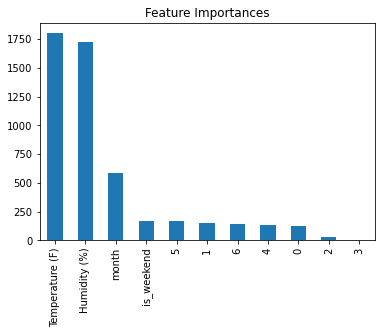

In [36]:
feat_imp = pd.Series(model.get_booster().get_score()).sort_values(ascending=False)
#clf.get_booster().get_score(importance_type="gain")
feat_imp.plot(kind='bar', title='Feature Importances')